In this notebook, we find a perturbation for $\mathcal{l}_{1}$-norm minimization and the un-trained network ConvDecoder. Note that the perturbation, obtained with Projected Gradient Descent (PGD) satisfies: <br>

$\epsilon = \frac{\lVert \text{perturbation norm} \rVert_2}{\lVert k\text{-space norm} \rVert_2} = 0.08$ <br>

**Note:** All reconstructions are for 4x acceleration.

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook/

import os
import sys
sys.path.insert(0,'/root/bart-0.6.00/python/')
import bart
os.environ['TOOLBOX_PATH'] = "/root/bart-0.6.00/"

import sigpy.mri as mr

import sigpy as sp
import sigpy.mri as mr
from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings('ignore')

from include import *

from PIL import Image
import PIL
import h5py
from common.evaluate import *
from pytorch_msssim import ms_ssim
import pickle
from common.subsample import RandomMaskFunc

from DIP_UNET_models.unet_and_tv.train_unet import UnetMRIModel
from DIP_UNET_models.unet_and_tv.varnet import VariationalNetworkModel

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
import torch.nn as nn


from include import transforms as transform

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    #os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    gpu = 3
    torch.cuda.set_device(gpu)
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor
devices = [torch.device("cuda:3"),
           torch.device("cuda:2"),
           torch.device("cuda:1"),
           torch.device("cuda:0"),]

num GPUs 4


# Plot function

In [18]:
def plot_(ims,titles,scores):
    fig = plt.figure(figsize=(18,10))
    for i in range(len(ims)):
        ax = fig.add_subplot(1,len(ims),i+1)
        ax.imshow(ims[i],'gray')
        ax.axis('off')
        title = titles[i]
        if title != 'ground truth':
            title += ' PSNR: %0.2f'%(scores[i])
        ax.set_title(title)
    plt.show()

# Load the data and create a mask

Kspace shape (number slices, number coils, x, y):  (40, 15, 640, 368)


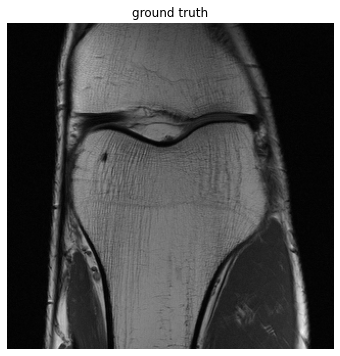

In [4]:
datapath = '/data/knee/multicoil_val/' # change this to your data path
filename =  datapath + 'file1000769.h5'

f = h5py.File(filename, 'r') # contains a kspace measurement f['kspace'] and rss reconstruction f['reconstruction_rss']
print("Kspace shape (number slices, number coils, x, y): ", f['kspace'].shape)

# which slice to consider in the following
slicenu = f["kspace"].shape[0]//2
slice_ksp = f['kspace'][slicenu]
slice_ksp_torchtensor = transform.to_tensor(slice_ksp)      # Convert from numpy array to pytorch tensor

orig = f["reconstruction_rss"][slicenu]
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.imshow(orig,"gray")
ax.set(title="ground truth")
ax.axis("off")
plt.show()
ksp = slice_ksp_torchtensor.clone()

under-sampling factor: 4.66


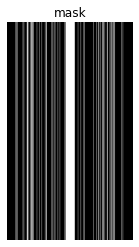

In [5]:
try: # if the file already has a mask
    temp = np.array([1 if e else 0 for e in f["mask"]])
    temp = temp[np.newaxis].T
    temp = np.array([[temp]])
    mask = transform.to_tensor(temp).type(dtype).detach().cpu()
except: # if we need to create a mask
    desired_factor = 4 # desired under-sampling factor
    undersampling_factor = 0
    tolerance = 0.03
    while undersampling_factor < desired_factor - tolerance or undersampling_factor > desired_factor + tolerance:
        mask_func = RandomMaskFunc(center_fractions=[0.07], accelerations=[desired_factor])  # Create the mask function object
        masked_kspace, mask = transform.apply_mask(slice_ksp_torchtensor, mask_func=mask_func)   # Apply the mask to k-space
        mask1d = var_to_np(mask)[0,:,0]
        undersampling_factor = len(mask1d) / sum(mask1d)

mask1d = var_to_np(mask)[0,:,0]

# The provided mask and data have last dim of 368, but the actual data is smaller.
# To prevent forcing the network to learn outside the data region, we force the mask to 0 there.
mask1d[:mask1d.shape[-1]//2-160] = 0 
mask1d[mask1d.shape[-1]//2+160:] =0
mask2d = np.repeat(mask1d[None,:], slice_ksp.shape[1], axis=0).astype(int) # Turning 1D Mask into 2D that matches data dimensions
mask2d = np.pad(mask2d,((0,),((slice_ksp.shape[-1]-mask2d.shape[-1])//2,)),mode='constant') # Zero padding to make sure dimensions match up
mask = transform.to_tensor( np.array( [[mask2d[0][np.newaxis].T]] ) ).type(dtype).detach().cpu()
print("under-sampling factor:",round(len(mask1d)/sum(mask1d),2))
plt.imshow(mask2d,"gray")
plt.title("mask")
plt.axis("off")
plt.show()

# l1-norm minimization

### Required functions

In [10]:
from pytorch_wavelets import DWTForward, DWTInverse
xfm = DWTForward(J=3, mode='zero', wave='db3').cuda(gpu)
def l1_solver(kspace, mask, sens_maps, gt, num_iters = 1000, lam=1e-2,LR=1e-1,weight_decay=0,):
    unders, _ = transform.apply_mask(kspace, mask = mask)
    mse = torch.nn.MSELoss()
    x = Variable(torch.zeros(unders.shape[1:])).type(dtype).to(devices[0])

    x.requires_grad = True
    optimizer = torch.optim.SGD([x], lr=LR,weight_decay=weight_decay)
    S = transform.to_tensor(sens_maps).type(dtype).to(devices[0])
    
    L = []
    trL = []
    for i in range(num_iters):
        def closure():
            imgs = torch.zeros(S.shape).type(dtype).to(devices[0])
            for j,s in enumerate(S):
                imgs[j,:,:,0] = x[:,:,0] * s[:,:,0] - x[:,:,1] * s[:,:,1]
                imgs[j,:,:,1] = x[:,:,0] * s[:,:,1] + x[:,:,1] * s[:,:,0]
            optimizer.zero_grad()
            out,_ = transform.apply_mask(transform.fft2(imgs),mask=mask) #transform.fft2(x)*mask
            #Rx = transform.fft2(x)
            Rx, Ux = xfm(x[:,None].permute(0,3,1,2))
            loss = mse( out , unders ) + lam*torch.norm(Rx,p=1) #yl
            loss.backward(retain_graph=True)
            trloss = mse(gt,transform.complex_abs(x))
            if i % 100 == 0:
                print("iteration{} -- fitting loss: {}  true loss: {}".format(i,loss.data,trloss.data),"\r",end='')
                #print("\n",torch.norm(Rx,p=1),mse(out,unders).data)
                L.append(loss.data.cpu().numpy()[np.newaxis][0])
                trL.append(trloss.data.cpu().numpy()[np.newaxis][0])
            return loss
        loss = optimizer.step(closure)
    return x, L, trL

In [11]:
def l1_attacker(ksp, mask, sens_maps, gt, num_iters = 1000, lam=1e-2,lam1=1e-1,lam2=1e-6,LR=1e-1,weight_decay=0,eps=0.04):
    mse = torch.nn.MSELoss()
    ### output image
    x = Variable(torch.zeros(ksp.shape[1:])).type(dtype)
    x.requires_grad = True
    ### perturbation
    e = Variable(torch.zeros(ksp.shape)).type(dtype)
    e.data.uniform_()
    e *= torch.norm(ksp)/torch.norm(e) / 10000
    e.requires_grad = True
    
    optimizer = torch.optim.SGD([x,e], lr=LR,weight_decay=weight_decay)
    S = transform.to_tensor(sens_maps).type(dtype)
    
    L = []
    E = []
    lam11 = lam22 = 0
    norm_ratios = []
    ctr = 0
    for i in range(num_iters):
        if i > 100:
            unders, _ = transform.apply_mask(ksp.type(dtype)+e, mask = mask.type(dtype))
            lam11 = lam1
            lam22 = lam2
        else:
            unders, _ = transform.apply_mask(ksp.type(dtype), mask = mask.type(dtype))
        def closure():
            imgs = torch.zeros(S.shape).type(dtype)
            for j,s in enumerate(S):
                imgs[j,:,:,0] = x[:,:,0] * s[:,:,0] - x[:,:,1] * s[:,:,1]
                imgs[j,:,:,1] = x[:,:,0] * s[:,:,1] + x[:,:,1] * s[:,:,0]
            optimizer.zero_grad()
            out,_ = transform.apply_mask(transform.fft2(imgs),mask=mask) #transform.fft2(x)*mask
            #Rx = transform.fft2(x)
            Rx, Ux = xfm(x[:,None].permute(0,3,1,2))
            loss = mse( out , unders ) + lam*torch.norm(Rx,p=1) - lam11 * mse(gt,imgs) #+ lam22 * torch.norm(e) #yl
            loss.backward()
            if i % 10 == 0:
                print("iteration{} -- fitting loss: {} pertn/kspn: {}".format(i,
                       loss.data,torch.norm(e)/torch.norm(ksp)),"\r",end='')
                L.append(loss.data.cpu().numpy()[np.newaxis][0])
                img = x.clone()
            return loss
        loss = optimizer.step(closure)
        
        ### projection onto the l2-norm ball denoted by eps 
        if torch.norm(e.data) / torch.norm(ksp) > eps:
            e.data = e.data * torch.norm(ksp) / (torch.norm(e.data) + 1e-10) # 1e-10 is a stabilizer
            e.data = e.data * eps
            ctr += 1
        ###
        E.append(e.data.cpu())
        
        norm_ratios = [torch.norm(e)/torch.norm(ksp)] + norm_ratios
        ### ending constraints
        if ctr > 100: # if more than 100 projections have been done
            break
        if len(norm_ratios) >= 200: # if the perturbation norm doesn't change more than 0.01 over 200 iterations
            if norm_ratios[0] - norm_ratios[-1] < 0.01:
                break
            else:
                norm_ratios.pop()
    return x,E

### sample test

In [20]:
### sensitivity map estimation
masked_kspace, _ = transform.apply_mask(slice_ksp_torchtensor.type(dtype).to(devices[0]), mask = mask.type(dtype).to(devices[0]))

zpad = masked_kspace.data.cpu().numpy()
zpad_complex = []
for m in range(zpad.shape[0]):
    zpad_complex += [zpad[m,:,:,0]+1j*zpad[m,:,:,1]]
zpad_complex = np.array(zpad_complex)
zpad_complex.shape
masked_complex_kspace = zpad_complex * np.array(slice_ksp_torchtensor.shape[0]*[list(mask2d)]) # shape: (15, 640, 368)
sens_maps = bart.bart(1, f'ecalib -d0 -m1', np.array([np.moveaxis(masked_complex_kspace,0,2)]))
sens_maps = np.moveaxis(sens_maps[0],2,0)

### clean reconstruction
print('clean reconstruction...')
out, loss, trueloss = l1_solver(slice_ksp_torchtensor.type(dtype).to(devices[0]).to(devices[0]),mask.to(devices[0]),sens_maps,transform.root_sum_of_squares(transform.complex_abs(
        transform.ifft2(slice_ksp_torchtensor.type(dtype).to(devices[0])))),num_iters=1000,lam=1e-18,LR=1e6)
clean_rec = center_crop(transform.complex_abs(out).data.cpu().numpy(),(320,320))
im1 = orig.copy()
im2 = clean_rec.copy()
im1 = (im1-im1.mean()) / im1.std()
im1 *= im2.std()
im1 += im2.mean()
psnr_c = psnr(np.array([im1]),np.array([im2]))
#

lam1 = 1
lam2 = 1e-8
e = 0.08
print('\nperturbation norm / kspace norm = {}'.format(e))
print('attack...')
out, E = l1_attacker(ksp.to(devices[0]),mask.to(devices[0]),sens_maps, transform.ifft2(ksp.type(dtype).to(devices[0])),num_iters=350,lam=1e-18,lam1=lam1,lam2=lam2,LR=1e6,eps=e)
print('\nperturbed reconstruction...')
out, loss, trueloss = l1_solver(slice_ksp_torchtensor.type(dtype).to(devices[0])+E[-1].to(devices[0]),mask.to(devices[0]),sens_maps,transform.root_sum_of_squares(transform.complex_abs(
    transform.ifft2(slice_ksp_torchtensor.type(dtype).to(devices[0])))),num_iters=1000,lam=1e-18,LR=1e6)
pert_rec = center_crop(transform.complex_abs(out).data.cpu().numpy(),(320,320))
im1 = orig.copy()
im2 = pert_rec.copy()
im1 = (im1-im1.mean()) / im1.std()
im1 *= im2.std()
im1 += im2.mean()
psnr_ = psnr(np.array([im1]),np.array([im2]))

clean reconstruction...
iteration900 -- fitting loss: 9.609610199592944e-13  true loss: 1.6405829472709854e-10 
perturbation norm / kspace norm = 0.08
attack...
iteration200 -- fitting loss: -15115250688.0 pertn/kspn: 0.07999999821186066 6 66  6  
perturbed reconstruction...


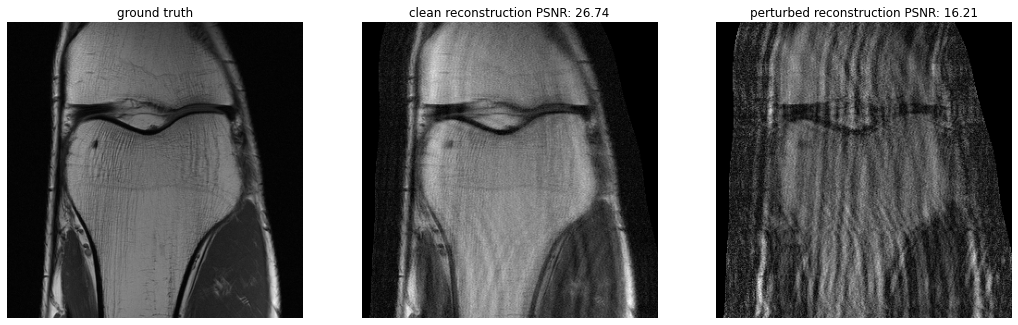

In [21]:
plot_([orig,clean_rec,pert_rec],['ground truth','clean reconstruction','perturbed reconstruction'],[0,psnr_c,psnr_])

# ConvDecoder

### Required functions

In [15]:
def convdecoder_attacker(net,
                        img_noisy_var,
                        num_channels,
                        img_clean_var,
                        ksp,
                        eps = 0.04,
                        lam1 = 1,
                        num_iter = 5000,
                        LR = 0.01,
                        late_entry=1000,
                        OPTIMIZER='adam',
                        opt_input = False,
                        mask_var = None,
                        mask = None,
                        mask1d = None,
                        mask2d = None,
                        apply_f = None,
                        net_input = None,
                        lsimg = None,
                        find_best=False,
                        weight_decay=0,
                        in_size=None,
                        retain_graph = False,
                        scale_out=1,
                       ):

    if net_input is not None:
        print("input provided")
    else:
        
        width,height = in_size
        shape = [1,num_channels, width, height]
        print("input shape: ", shape)
        net_input = Variable(torch.zeros(shape)).type(dtype).to(devices[0])
        net_input.data.uniform_()
        net_input.data *= 1./10
    
    net_input = net_input.type(dtype).to(devices[0])
    net_input_saved = net_input.data.clone()
    noise = net_input.data.clone()
    p = [x for x in net.parameters() ]

    if(opt_input == True): # optimizer over the input as well
        net_input.requires_grad = True
        p += [net_input]

    ################################################ additive perturbation
    e = Variable(torch.zeros(ksp.shape)).type(dtype).to(devices[0])
    e.data.uniform_()
    e *= torch.norm(ksp)/torch.norm(e) / 10000
    e.requires_grad = True
    p += [e]
    ################################################
    
    mse_wrt_noisy = np.zeros(num_iter)
    mse_wrt_truth = np.zeros(num_iter)
    
    
    if OPTIMIZER == 'SGD':
        print("optimize with SGD", LR)
        optimizer = torch.optim.SGD(p, lr=LR,momentum=0.9,weight_decay=weight_decay)
    elif OPTIMIZER == 'adam':
        print("optimize with adam", LR)
        optimizer = torch.optim.Adam(p, lr=LR,weight_decay=weight_decay)
    elif OPTIMIZER == 'LBFGS':
        print("optimize with LBFGS", LR)
        optimizer = torch.optim.LBFGS(p, lr=LR)
    elif OPTIMIZER == "adagrad":
        print("optimize with adagrad", LR)
        optimizer = torch.optim.Adagrad(p, lr=LR,weight_decay=weight_decay)

    mse = torch.nn.MSELoss()
    
    if find_best:
        best_net = copy.deepcopy(net)
        best_mse = 1000000.0
    
    norm_ratios = []
    ctr = 0
    recs = []
    E = []
    for i in range(num_iter):
        if OPTIMIZER == "SGD":
            for param_group in optimizer.param_groups:
                param_group['lr'] = LR + i*1e-3
        def closure():
            
            optimizer.zero_grad()
            try:
                out = net(net_input.type(dtype).to(devices[0]),scale_out=scale_out)
            except:
                out = net(net_input.type(dtype).to(devices[0]))
                
            # training loss
            if mask_var is not None:
                loss = mse( out * mask_var , img_noisy_var * mask_var )
            elif apply_f:
                im = Variable(transform.ifft2(ksp)[None,:])
                im_hat = Variable(torch.zeros(im.shape)).type(dtype).to(devices[0])
                for j in range(out.shape[1]//2):
                    im_hat[0,j,:,:,0] = out[0,2*j,:,:]
                    im_hat[0,j,:,:,1] = out[0,2*j+1,:,:]
                if i < late_entry:
                    target = img_noisy_var.clone()
                    lam11 = 0
                else:
                    target = img_noisy_var+ (mask*e)[None,:]
                    lam11 = lam1
                loss = mse( apply_f(out,mask2d) , target) - lam11 * mse(im_hat,im) 
            else:
                loss = mse(out, img_noisy_var)
        
            loss.backward(retain_graph=retain_graph)
            
            mse_wrt_noisy[i] = loss.data.cpu().numpy()

            # the actual loss 
            true_loss = mse( Variable(out.data, requires_grad=False).type(dtype).to(devices[0]), img_clean_var.type(dtype).to(devices[0]) )
            mse_wrt_truth[i] = true_loss.data.cpu().numpy()

            
            if i > late_entry-10 and i % 5 == 0:
                if lsimg is not None:
                    ### compute ssim and psnr ###
                    out_chs = out.data.cpu().numpy()[0]
                    out_imgs = channels2imgs(out_chs)
                    # least squares reconstruciton
                    orig = crop_center2( root_sum_of_squares2(var_to_np(lsimg)) , 320,320)

                    # decoder reconstruction
                    rec = crop_center2(root_sum_of_squares2(out_imgs),320,320)
                    recs.append(rec)
                    ### ###
                
                trloss = loss.data
                true_loss = true_loss.data
                try:
                    out2 = net(Variable(net_input_saved).type(dtype).to(devices[0]),scale_out=scale_out)
                except:
                    out2 = net(Variable(net_input_saved).type(dtype).to(devices[0]))
                loss2 = mse(out2, img_clean_var).data
                print ('Iteration %05d    Train loss %f  Actual loss %f Actual loss orig %f norm: %f' % (i, trloss,true_loss,loss2,torch.norm(e)/torch.norm(ksp)), '\r', end='')
            
            return loss   
        
        loss = optimizer.step(closure)
        
        ### projection onto the l2-norm ball denoted by eps 
        if torch.norm(e.data) / torch.norm(ksp) > eps:
            e.data = e.data * torch.norm(ksp) / (torch.norm(e.data) + 1e-10) # 1e-10 is a stabilizer
            e.data = e.data * eps
            ctr += 1
        ###
        
        ### ending constraints
        if i > late_entry:
            E.append(e.data.cpu())
        
        if find_best:
            # if training loss improves by at least one percent, we found a new best net
            lossval = loss.data
            if best_mse > 1.005*lossval:
                best_mse = lossval
                best_net = copy.deepcopy(net)
                if opt_input:
                    best_ni = net_input.data.clone()
                else:
                    best_ni = net_input_saved.clone()
       
        
    if find_best:
        net = best_net
        net_input_saved = best_ni
    return E,net_input_saved, net       

### sample test

In [16]:
### create the network
num_channels = 200
num_layers = 7
strides = [1]*(num_layers-1)
in_size = [10,5]
kernel_size = 3
output_depth = ksp.numpy().shape[0]*2
out_size = ksp.numpy().shape[1:-1]

net = convdecoder(out_size,in_size,output_depth,
                     num_layers,strides,num_channels, act_fun = nn.ReLU(),
                     skips=False,need_sigmoid=False,bias=True, need_last = True,
                     kernel_size=kernel_size,upsample_mode="nearest").type(dtype).to(devices[0])
### fix scaling for ConvDecoder
scaling_factor,ni = get_scale_factor(net,
                                   num_channels,
                                   in_size,
                                   ksp,)
slice_ksp_torchtensor1 = ksp.type(dtype).to(devices[0]) * scaling_factor
masked_kspace, mask = transform.apply_mask(slice_ksp_torchtensor1, mask = mask.type(dtype).to(devices[0]))
unders_measurement = Variable(masked_kspace[None,:])
sampled_image2 = transform.ifft2(masked_kspace)
measurement = slice_ksp_torchtensor1.unsqueeze(0).type(dtype).to(devices[0])
lsimg = lsreconstruction(measurement)
out = []
for img in sampled_image2:
    out += [ img[:,:,0].data.cpu().numpy() , img[:,:,1].data.cpu().numpy() ]
lsest = torch.tensor(np.array([out]))


### clean reconstruction
print('clean reconstruction...')
import copy
scale_out,sover,pover,par_mse_n, par_mse_t, parni, pert_net = fitr(copy.deepcopy(net),
                                                            unders_measurement,
                                                            Variable(lsest).type(dtype).to(devices[0]),
                                                            mask2d,
                                                            num_iter=10000,
                                                            LR=0.008,
                                                            apply_f = forwardm,
                                                            lsimg = lsimg,
                                                            find_best=True,
                                                            net_input = ni.data.cpu().type(dtype).to(devices[0]),
                                                            OPTIMIZER = "adam"
                                                            )
clean_rec = data_consistency(pert_net, parni, mask1d, slice_ksp_torchtensor1.data.cpu())
im1 = orig.copy()
im2 = clean_rec.copy()
im1 = (im1-im1.mean()) / im1.std()
im1 *= im2.std()
im1 += im2.mean()
psnr_c = psnr(np.array([im1]),np.array([im2]))
#

clean reconstruction...
optimize with adam 0.008


In [17]:
### attack
print('\nperturbation norm / kspace norm = {}'.format(e))
print('attack...')

import copy
e = 0.08
numit = 400
LR = 8e-3
E, attacked_ni, attacked_net = convdecoder_attacker(in_size = in_size,
                                                    num_channels=num_channels,
                                                    num_iter=numit,
                                                    LR=LR,
                                                    mask = mask,
                                                    mask1d = mask1d,
                                                    mask2d = mask2d,
                                                    apply_f = forwardm,
                                                    img_noisy_var=unders_measurement,
                                                    net=copy.deepcopy(net),
                                                    ksp=slice_ksp_torchtensor1, lam1 = 0.05, late_entry=100, eps=e,
                                                    img_clean_var=Variable(lsest).type(dtype),
                                                    lsimg = lsimg,
                                                    find_best=True,
                                                    net_input = ni,
                                                    OPTIMIZER = "adam"
                                                  )
print('\nperturbed reconstruction...')
skt = slice_ksp_torchtensor1.type(dtype).to(devices[0]) + E[-1].type(dtype).to(devices[0])
print("norm ratio: {}".format(torch.norm(E[-1]) / torch.norm(slice_ksp_torchtensor1.type(dtype))))
masked_kspace, mask = transform.apply_mask(skt, mask = mask.type(dtype).to(devices[0]))
unders_measurement = Variable(masked_kspace[None,:])
sampled_image2 = transform.ifft2(masked_kspace)
measurement = skt.unsqueeze(0).type(dtype) .to(devices[0])
lsimg = lsreconstruction(measurement)
out = []
for img in sampled_image2:
    out += [ img[:,:,0].data.cpu().numpy() , img[:,:,1].data.cpu().numpy() ]
lsest = torch.tensor(np.array([out]))

scale_out,sover,pover,par_mse_n, par_mse_t, parni, pert_net = fitr(copy.deepcopy(net),
                                                                unders_measurement,
                                                                Variable(lsest).type(dtype).to(devices[0]),
                                                                mask2d,
                                                                num_iter=10000,
                                                                LR=0.008,
                                                                apply_f = forwardm,
                                                                lsimg = lsimg,
                                                                find_best=True,
                                                                net_input = ni.data.cpu().type(dtype).to(devices[0]),
                                                                OPTIMIZER = "adam"
                                                                )

pert_rec = data_consistency(pert_net, parni, mask1d, slice_ksp_torchtensor1.data.cpu())


im1 = orig.copy()
im2 = pert_rec.copy()
im1 = (im1-im1.mean()) / im1.std()
im1 *= im2.std()
im1 += im2.mean()
psnr_ = psnr(np.array([im1]),np.array([im2]))


perturbation norm / kspace norm = 0.08
attack...
input provided
optimize with adam 0.008
Iteration 00395    Train loss 0.000430  Actual loss 0.007992 Actual loss orig 0.007992 norm: 0.080000 
perturbed reconstruction...
norm ratio: 0.07999927550554276
optimize with adam 0.008


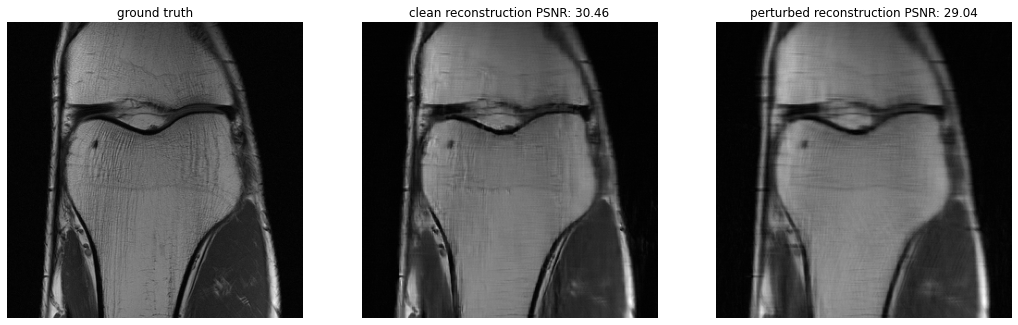

In [19]:
plot_([orig,clean_rec,pert_rec],['ground truth','clean reconstruction','perturbed reconstruction'],[0,psnr_c,psnr_])

As shown, the perturbations has caused blurry artifacts in the reconstruction. Also, depending on the hyperparameters (lambda and LR) and $\epsilon$, this effect can be more severe.